Q. MNIST 데이터셋에 대해서 Pytorch를 적용하여 모델 구성 변경, 조기 학습 중단을 수행, Best model을 저장 한 후 불러와서 테스터로 평가한 결과 출력

In [3]:
import torch

# 예시 출력 텐서
outputs=torch.tensor([[0.1,0.3,0.6],[0.2, 0.7, 0.1]])

## 가장 큰 값을 가지는 클래스 인텍스를 추출
_, predicted=torch.max(outputs, 0)

print(predicted)    # tensor([1, 1, 0])

## 가장 큰 값을 가지는 클래스 인텍스를 추출
_, predicted=torch.max(outputs, 1)

print(predicted)    # tensor([2,1])

tensor([1, 1, 0])
tensor([2, 1])


- outputs는 2x3 크기의 텐서입니다. 여기서 각 행은 서로 다른 예시에 대한 출력 값(로짓)입니다.
- 예를 들어, 첫 번째 행 [0.1, 0.3, 0.6]은 첫 번째 예시에 대한 모델의 출력 값이고, 두 번째 행 [0.2, 0.7, 0.1]은 두 번째 예시에 대한 모델의 출력 값입니다.
- 각 열은 서로 다른 클래스에 대응하며, 예를 들어 첫 번째 열은 클래스 0, 두 번째 열은 클래스 1, 세 번째 열은 클래스 2에 해당합니다.

- torch.max(outputs, 0)는 outputs 텐서에서 주어진 축(axis, 여기서는 dim=0)을 기준으로 가장 큰 값을 찾습니다.
- dim=0은 **열(column)**을 기준으로 연산을 수행함을 의미합니다. 즉, 각 열에서 가장 큰 값을 찾고, 그 값이 있는 인덱스를 반환합니다.
- torch.max(outputs, 0)는 두 개의 값을 반환합니다:
  - 첫 번째 값은 각 열에서 가장 큰 값들 (여기서는 사용하지 않음, _로 무시).
  - 두 번째 값은 그 가장 큰 값들의 인덱스 (여기서는 predicted로 저장).
- predicted에는 각 열에서 가장 큰 값을 가지는 인덱스가 저장됩니다.
- 결과로 tensor([2, 1])가 출력되는데, 이는 다음을 의미합니다:
  - 첫 번째 열에서는 두 번째 행(인덱스 1)의 값 0.2가 더 크지만, 세 번째 열에서는 두 번째 행(인덱스 1)의 값 0.7이 가장 큽니다.
  - 결과적으로 첫 번째 열에서는 인덱스 1이, 두 번째 열에서는 인덱스 1이 선택됩니다.

In [4]:
import torch
import torch.nn as nn
import  torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import  transforms, ToTensor
import torch.nn.functional as F
import torch.optim as optim

### Normalize 시킴; MNIST 데이터셋을 위한 전처리 과정 정의
transform = transforms.Compose([
    transforms.ToTensor(),                ## 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))    ## 이미지를 평균 0.5, 표준편차 0.5로 정규화하여 [-1,1] 범위로 조정
])

## 공개 데이터셋에서 학습 데이터를 down
training_data=torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data=torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

## 훈련 데이터셋을 훈련 및 검증 세트로 분할
train_size=int(0.8*len(training_data))  # 80%
val_size=len(training_data)-train_size  # 검증 세트 크기 20%
train_dataset, val_dataset=random_split(training_data, [train_size, val_size])    ## 분할 실행

# 데이터 로더를 생성
trainloader=DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader=DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader=DataLoader(test_data, batch_size=64, shuffle=False)

# 모델을 정의
class MyModel(nn.Module):     # NeuralNetwork 클래스: PyTorch의 신경망 모듈(nn.Module)을 상속하여 간단한 신경망을 정의
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5) # 컨볼루션 레이어 정의(입력 채널 1, 출력 채널 20, 커널 크기 5)
        self.pool = nn.MaxPool2d(2, 2)   # 맥스풀링 레이어 정의(커널 크기 2, 스트라이드 2)
        self.flatten = nn.Flatten() # 텐서 평탄화
        self.fc1 = nn.Linear(2880, 50)    ## 완전 연결 레이어(입력: 2880, 출력 크기 50)
        self.fc2 = nn.Linear(50, 10)      ## 출력 완전 연결 레이어(클래스 수 10: 0~9 숫자)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 컨볼루션 레이어, 맥스풀링 레이어, ReLU 활성화 함수를 통과
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 인스턴스 생성
model = MyModel()

## 손실 함수 및 최적화 알고리즘 지정
criterion = nn.CrossEntropyLoss()     ## 크로스 엔트로피 손실함수
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD 최적화 알고리즘


## 모델 훈련
best_val_loss=float('inf')      ## 검증 손실을 추적하기 위한 변수 초기화
patience, trials=5, 0 ## 조기 종료를 위한 기준 설정
num_epochs = 20

for epoch in range(num_epochs):
    model.train()     ## 모델을 훈련 모드로 설정
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()   # 그레디언트 초기화
        outputs = model(inputs) # 모델을 통한 순전파
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward()         # 역전파
        optimizer.step()        # 파라미터 업데이트
        running_loss += loss.item()

    ## 검증단계
    val_loss=0
    model.eval()    # 모델을 평가 모드로 설정
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs=model(inputs)
            loss=criterion(outputs, labels)
            val_loss+=loss.item()

    val_loss /= len(valloader)  # 평균 검증 손실 계산
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}, Validation Loss: {val_loss}")

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.6f}--->{val_loss:.6f} \t Saving The Model')
        best_val_loss=val_loss
        trials=0
        torch.save(model.state_dict(), "best_model.pth")  # 모델 저장
    else:
        trials+=1
        if trials>=patience:    # 조기 종료 조건 충족 확인
            print("Early stopping triggered")
            break

####### 모델 불러오기
model.load_state_dict(torch.load('best_model.pth'))   # 모델 상태 불러오기

# 모델 평가
correct=0
total=0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs=model(inputs)
        _, predicted=torch.max(outputs.data, 1)       # torch.max(input,dim) "dim"은 차원을 의미 클래스의 점수 중 최대값을 찾음
        total +=labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100*correct / total  # 정확도 계산
print(f'Accuracy on the 10000 test images: {accuracy}%')    ## 정확도 출력

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 50833261.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1773478.77it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13612110.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3003394.10it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Train Loss: 0.2512313482699295, Validation Loss: 0.10030398593145481
Validation Loss Decreased(inf--->0.100304 	 Saving The Model
Epoch 2, Train Loss: 0.07351759933369854, Validation Loss: 0.07025610065048045
Validation Loss Decreased(0.100304--->0.070256 	 Saving The Model
Epoch 3, Train Loss: 0.05056027900241315, Validation Loss: 0.06641648201633522
Validation Loss Decreased(0.070256--->0.066416 	 Saving The Model
Epoch 4, Train Loss: 0.040161620744814476, Validation Loss: 0.0631835974277334
Validation Loss Decreased(0.066416--->0.063184 	 Saving The Model
Epoch 5, Train Loss: 0.03184993829453985, Validation Loss: 0.06199877888789063
Validation Loss Decreased(0.063184--->0.061999 	 Saving The Model
Epoch 6, Train Loss: 0.02627621601902259, Validation Loss: 0.06358270578524791
Epoch 7, Train Loss: 0.02207209325748651, Validation Loss: 0.052524131715317515
Validation Loss Decreased(0.061999--->0.052524 	 Saving The Model
Epoch 8, Train Loss: 0.017765467602798405, Validation Lo

<ipython-input-4-9a125266707a>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))   # 모델 상태 불러오기


Accuracy on the 10000 test images: 98.77%


#### 코드 분석
1. 필요한 모듈 임포트
- torch: PyTorch의 핵심 라이브러리.
- torch.nn: 신경망을 정의하는 데 필요한 모듈.
- torchvision: 이미지 데이터셋과 전처리, 모델을 제공하는 라이브러리.
- DataLoader, random_split: 데이터셋을 배치 단위로 나누고, 학습/검증 데이터셋으로 분리하는 데 사용.
- transforms: 이미지 전처리 도구 모음.
- torch.nn.functional (F): 함수형 신경망 모듈로, 활성화 함수나 손실 함수 등을 제공.
- torch.optim: 최적화 알고리즘을 제공하는 모듈.

###### 강사님
- torch: 이것은 메인 PyTorch 라이브러리입니다. 여기에는 GPU를 통한 가속 텐서 계산 지원, 신경망 훈련을 용이하게 하는 자동 차별화, 모델 구축 및 훈련을 위한 다양한 유틸리티가 포함됩니다.
- torch.nn: 레이어, 활성화 함수, 손실 함수와 같은 신경망의 구성 요소를 제공하는 PyTorch의 하위 모듈입니다. 신경망의 아키텍처를 정의하는 데 필수적입니다.
- torch.nn.function: 이 모듈에는 torch.nn 레이어에서 사용되는 기능이 포함되어 있습니다. 입력 데이터 및 가중치에 이러한 함수를 직접 사용할 수 있으므로 일부 작업에 더 많은 유연성을 제공합니다. 여기에는 활성화, 손실 계산 및 상태(즉, 가중치)를 유지하지 않는 다양한 기타 작업을 위한 함수가 포함됩니다.
- torch.optim: 이 하위 모듈은 SGD(Stochastic Gradient Descent), Adam 등과 같은 신경망 훈련을 위한 최적화 알고리즘을 제공합니다. 이러한 최적화 프로그램은 계산된 기울기를 기반으로 네트워크의 가중치를 업데이트하는 데 사용됩니다.
- torchvision: 이미지 데이터 작업을 위한 유틸리티를 제공하는 PyTorch 프로젝트의 패키지입니다. 여기에는 사전 정의된 데이터세트(예: MNIST, CIFAR10, FashionMNIST), 모델 아키텍처(예: ResNet, AlexNet) 및 전처리를 위한 일반적인 이미지 변환이 포함됩니다.
- torchvision.transforms: 일반적인 이미지 변환을 제공하는 torchvision 내의 모듈입니다. 이는 이미지를 신경망에 공급하기 전에 데이터 증대 및 이미지 전처리에 사용될 수 있습니다. 예로는 크기 조정, 정규화, 텐서로 변환 등이 있습니다.
- SubsetRandomSampler: 교체 없이 데이터세트에서 요소를 무작위로 샘플링하는 데 사용되는 도구입니다. 데이터 세트를 훈련 및 검증/테스트 세트로 분할하거나 모델 훈련을 위해 사용자 정의 데이터 샘플링 전략을 구현하려는 경우에 특히 유용

2. 데이터셋 전처리 및 로드
- transforms.Compose: 여러 변환을 순차적으로 적용.
- ToTensor: 이미지를 PyTorch 텐서로 변환.
- Normalize: 픽셀 값을 [0, 1] 범위에서 평균이 0.5, 표준편차가 0.5가 되도록 정규화.
- datasets.MNIST: MNIST 데이터셋을 다운로드하고 로드.

3. 훈련 데이터셋을 학습/검증 세트로 분할
- random_split: 데이터셋을 무작위로 훈련 및 검증 세트로 분할.

4. 데이터 로더 생성
- DataLoader: 데이터를 배치 단위로 로드하며, shuffle=True로 설정하면 데이터를 무작위로 섞음.

5. 모델 정의
- MyModel: CNN 모델을 정의하는 클래스.
- Conv2d: 2D 컨볼루션 레이어, 이미지의 특징을 추출.
- MaxPool2d: 풀링 레이어, 특징 맵을 다운샘플링.
- Flatten: 다차원 텐서를 1차원으로 변환.
- Linear: 완전 연결 레이어.

6. 모델 인스턴스 생성
model: MyModel 클래스의 인스턴스 생성.

7. 손실 함수 및 최적화 알고리즘 지정
- criterion: 모델의 예측과 실제 값 간의 차이를 계산하는 손실 함수.
- optimizer: 학습 과정에서 모델의 파라미터를 업데이트하는 최적화 알고리즘.

8. 모델 훈련
- model.train(): 모델을 학습 모드로 설정.
- optimizer.zero_grad(): 이전 배치의 그라디언트를 초기화.
- loss.backward(): 손실의 역전파 계산.
- optimizer.step(): 파라미터 업데이트.
- model.eval(): 모델을 평가 모드로 설정, 드롭아웃이나 배치 정규화가 비활성화됨.
- torch.save(): 모델의 파라미터를 저장.
- Early stopping: 검증 손실이 개선되지 않을 때 학습을 조기에 종료.

9. 모델 불러오기 및 평가
- model.load_state_dict(): 저장된 모델의 파라미터를 불러옴.
- torch.no_grad(): 그라디언트 계산을 비활성화하여 메모리 절약 및 연산 속도 증가.
- torch.max(): 예측한 클래스의 최대값과 그 인덱스를 반환.
- accuracy: 모델의 테스트 데이터셋에 대한 정확도 계산 및 출력.


#### 이 코드 전체는 MNIST 데이터셋에 대해 간단한 CNN을 정의하고 학습 및 평가하는 과정을 포함합니다. 조기 종료와 모델 저장 등의 기술도 포함되어 있어 실전에서 유용하게 사용할 수 있는 코드입니다.

#### Early Stop Logic
- **얼리 스탑(Early Stopping)**의 조건은 **검증 손실(Validation Loss)**이 일정 에포크(epoch) 동안 개선되지 않을 때 발생

1. 초기 설정
- patience: 얼리 스탑을 활성화하기 전에 기다릴 수 있는 최대 에포크 수를 설정합니다. 여기서는 patience = 5로 설정되어 있습니다.
- trials: 현재 개선되지 않은 에포크의 수를 추적하는 변수로, 처음에는 0으로 초기화됩니다.
- best_val_loss: 현재까지의 가장 낮은 검증 손실 값을 저장하는 변수입니다. 처음에는 무한대로 설정되어 첫 번째 에포크에서 무조건 갱신되도록 합니다.


2. 검증 손실이 개선되었을 때:
```python
if val_loss < best_val_loss:
    print(f'Validation Loss Decreased({best_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
    best_val_loss = val_loss
    trials = 0
    torch.save(model.state_dict(), "best_model.pth")  # 모델 저장
```    
- 매 에포크마다 계산된 val_loss가 이전의 best_val_loss보다 작으면, 검증 손실이 개선된 것으로 간주됩니다.
- 이 경우:
  - best_val_loss가 현재의 val_loss 값으로 갱신됩니다.
  - trials 변수는 0으로 초기화됩니다 (개선되지 않은 에포크 수를 초기화).
  - 모델의 현재 파라미터가 파일(best_model.pth)로 저장됩니다.

3. 검증 손실이 개선되지 않았을 때:
```python
코드 복사
else:
    trials += 1
    if trials >= patience:  # 조기 종료 조건 충족 확인
        print("Early stopping triggered")
        break
```        
- 만약 val_loss가 best_val_loss보다 크거나 같다면, 검증 손실이 개선되지 않은 것으로 간주됩니다.
- 이 경우:
  - trials 변수의 값이 1 증가합니다.
  - 만약 trials 값이 patience 값(여기서는 5) 이상이면, 즉, 검증 손실이 5 에포크 연속으로 개선되지 않으면, 얼리 스탑이 활성화됩니다.
  - 얼리 스탑이 활성화되면 break 문에 의해 훈련 루프가 중단

Q. PyTorch를 사용하여 FashionMNIST 데이터세트에 대한 분류 모델링 및 평가를 다음과 같은 단계로 수행하세요.
- 1단계: 신경망 모델 정의
- 2단계: FashionMNIST 데이터셋 로드
- 3단계: 네트워크, 손실 함수, 최적화 알고리즘 초기화
- 4단계: 조기 종료를 포함한 모델 학습 및 best model 저장
- 5단계: best model을 로드하고 테스트 데이터셋으로 평가

In [5]:
import torch
import torch.nn as nn
import  torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import  transforms, ToTensor
import torch.nn.functional as F
import torch.optim as optim

### Normalize 시킴; MNIST 데이터셋을 위한 전처리 과정 정의
transform = transforms.Compose([
    transforms.ToTensor(),                ## 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))    ## 이미지를 평균 0.5, 표준편차 0.5로 정규화하여 [-1,1] 범위로 조정
])

## 공개 데이터셋에서 학습 데이터를 down
training_data=datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data=datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

## 훈련 데이터셋을 훈련 및 검증 세트로 분할
train_size=int(0.8*len(training_data))  # 80%
val_size=len(training_data)-train_size  # 검증 세트 크기 20%
train_dataset, val_dataset=random_split(training_data, [train_size, val_size])    ## 분할 실행

# 데이터 로더를 생성
trainloader=DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader=DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader=DataLoader(test_data, batch_size=64, shuffle=False)

# 모델을 정의
class MyModel(nn.Module):     # NeuralNetwork 클래스: PyTorch의 신경망 모듈(nn.Module)을 상속하여 간단한 신경망을 정의
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5) # 컨볼루션 레이어 정의(입력 채널 1, 출력 채널 20, 커널 크기 5)
        self.pool = nn.MaxPool2d(2, 2)   # 맥스풀링 레이어 정의(커널 크기 2, 스트라이드 2)
        self.flatten = nn.Flatten() # 텐서 평탄화
        self.fc1 = nn.Linear(2880, 50)    ## 완전 연결 레이어(입력: 2880, 출력 크기 50)
        self.fc2 = nn.Linear(50, 10)      ## 출력 완전 연결 레이어(클래스 수 10: 0~9 숫자)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 컨볼루션 레이어, 맥스풀링 레이어, ReLU 활성화 함수를 통과
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 인스턴스 생성
model = MyModel()

## 손실 함수 및 최적화 알고리즘 지정
criterion = nn.CrossEntropyLoss()     ## 크로스 엔트로피 손실함수
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD 최적화 알고리즘


## 모델 훈련
best_val_loss=float('inf')      ## 검증 손실을 추적하기 위한 변수 초기화
patience, trials=5, 0 ## 조기 종료를 위한 기준 설정
num_epochs = 20

for epoch in range(num_epochs):
    model.train()     ## 모델을 훈련 모드로 설정
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()   # 그레디언트 초기화
        outputs = model(inputs) # 모델을 통한 순전파
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward()         # 역전파
        optimizer.step()        # 파라미터 업데이트
        running_loss += loss.item()

    ## 검증단계
    val_loss=0
    model.eval()    # 모델을 평가 모드로 설정
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs=model(inputs)
            loss=criterion(outputs, labels)
            val_loss+=loss.item()

    val_loss /= len(valloader)  # 평균 검증 손실 계산
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}, Validation Loss: {val_loss}")

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.6f}--->{val_loss:.6f} \t Saving The Model')
        best_val_loss=val_loss
        trials=0
        torch.save(model.state_dict(), "best_model.pth")  # 모델 저장
    else:
        trials+=1
        if trials>=patience:    # 조기 종료 조건 충족 확인
            print("Early stopping triggered")
            break

####### 모델 불러오기
model.load_state_dict(torch.load('best_model.pth'))   # 모델 상태 불러오기

# 모델 평가
correct=0
total=0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs=model(inputs)
        _, predicted=torch.max(outputs.data, 1)       # torch.max(input,dim) "dim"은 차원을 의미 클래스의 점수 중 최대값을 찾음
        total +=labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100*correct / total  # 정확도 계산
print(f'Accuracy on the 10000 test images: {accuracy}%')    ## 정확도 출력

100%|██████████| 26421880/26421880 [00:02<00:00, 9689357.53it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302793.95it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5507861.24it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18727039.89it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1, Train Loss: 0.5261194069782893, Validation Loss: 0.3720423048956597
Validation Loss Decreased(inf--->0.372042 	 Saving The Model
Epoch 2, Train Loss: 0.33390364271402356, Validation Loss: 0.336576510854858
Validation Loss Decreased(0.372042--->0.336577 	 Saving The Model
Epoch 3, Train Loss: 0.28900693960984547, Validation Loss: 0.28581551537710304
Validation Loss Decreased(0.336577--->0.285816 	 Saving The Model
Epoch 4, Train Loss: 0.26079645795623463, Validation Loss: 0.27605336662778196
Validation Loss Decreased(0.285816--->0.276053 	 Saving The Model
Epoch 5, Train Loss: 0.23651611021657784, Validation Loss: 0.2613422862313529
Validation Loss Decreased(0.276053--->0.261342 	 Saving The Model
Epoch 6, Train Loss: 0.22119237097601097, Validation Loss: 0.27072479639281616
Epoch 7, Train Loss: 0.2032116431593895, Validation Loss: 0.258893304445008
Validation Loss Decreased(0.261342--->0.2

<ipython-input-5-b4eec44442f9>:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))   # 모델 상태 불러오기


Accuracy on the 10000 test images: 90.13%


#### 에폭에 따른 Loss와 Accuracy를 Plot하기 위해 수정

In [6]:
import torch
import torch.nn as nn
import  torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import  transforms, ToTensor
import torch.nn.functional as F
import torch.optim as optim

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

### Normalize 시킴; MNIST 데이터셋을 위한 전처리 과정 정의
transform = transforms.Compose([
    transforms.ToTensor(),                ## 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))    ## 이미지를 평균 0.5, 표준편차 0.5로 정규화하여 [-1,1] 범위로 조정
])

## 공개 데이터셋에서 학습 데이터를 down
training_data=datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data=datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

## 훈련 데이터셋을 훈련 및 검증 세트로 분할
train_size=int(0.8*len(training_data))  # 80%
val_size=len(training_data)-train_size  # 검증 세트 크기 20%
train_dataset, val_dataset=random_split(training_data, [train_size, val_size])    ## 분할 실행

# 데이터 로더를 생성
trainloader=DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader=DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader=DataLoader(test_data, batch_size=64, shuffle=False)

# 모델을 정의
class MyModel(nn.Module):     # NeuralNetwork 클래스: PyTorch의 신경망 모듈(nn.Module)을 상속하여 간단한 신경망을 정의
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5) # 컨볼루션 레이어 정의(입력 채널 1, 출력 채널 20, 커널 크기 5)
        self.pool = nn.MaxPool2d(2, 2)   # 맥스풀링 레이어 정의(커널 크기 2, 스트라이드 2)
        self.flatten = nn.Flatten() # 텐서 평탄화
        self.fc1 = nn.Linear(2880, 50)    ## 완전 연결 레이어(입력: 2880, 출력 크기 50)
        self.fc2 = nn.Linear(50, 10)      ## 출력 완전 연결 레이어(클래스 수 10: 0~9 숫자)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 컨볼루션 레이어, 맥스풀링 레이어, ReLU 활성화 함수를 통과
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 인스턴스 생성
model = MyModel().to(device)

## 손실 함수 및 최적화 알고리즘 지정
criterion = nn.CrossEntropyLoss()     ## 크로스 엔트로피 손실함수
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD 최적화 알고리즘


## 모델 훈련
best_val_loss=float('inf')      ## 검증 손실을 추적하기 위한 변수 초기화
patience, trials=5, 0 ## 조기 종료를 위한 기준 설정
num_epochs = 20

import matplotlib.pyplot as plt

train_losses = []
val_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()     ## 모델을 훈련 모드로 설정
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()   # 그레디언트 초기화
        outputs = model(inputs) # 모델을 통한 순전파
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward()         # 역전파
        optimizer.step()        # 파라미터 업데이트
        running_loss += loss.item()
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)  # 훈련 손실 저장

    ## 검증단계
    val_loss=0
    correct = 0
    total = 0
    model.eval()    # 모델을 평가 모드로 설정
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs=model(inputs)
            loss=criterion(outputs, labels)
            val_loss+=loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)  # 평균 검증 손실 계산
    accuracy = 100 * correct / total  # 정확도 계산

    val_losses.append(val_loss)  # 검증 손실 저장
    accuracies.append(accuracy)  # 정확도 저장

    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}, Validation Loss: {val_loss}")

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.6f}--->{val_loss:.6f} \t Saving The Model')
        best_val_loss=val_loss
        trials=0
        torch.save(model.state_dict(), "best_model.pth")  # 모델 저장
    else:
        trials+=1
        if trials>=patience:    # 조기 종료 조건 충족 확인
            print("Early stopping triggered")
            break

####### 모델 불러오기
model.load_state_dict(torch.load('best_model.pth'))   # 모델 상태 불러오기

# 모델 평가
correct=0
total=0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs=model(inputs)
        _, predicted=torch.max(outputs.data, 1)       # torch.max(input,dim) "dim"은 차원을 의미 클래스의 점수 중 최대값을 찾음
        total +=labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100*correct / total  # 정확도 계산
print(f'Accuracy on the 10000 test images: {accuracy}%')    ## 정확도 출력

Epoch 1, Train Loss: 0.5128259308139483, Validation Loss: 0.38920259051659006
Validation Loss Decreased(inf--->0.389203 	 Saving The Model
Epoch 2, Train Loss: 0.32935635245839756, Validation Loss: 0.33366256124003135
Validation Loss Decreased(0.389203--->0.333663 	 Saving The Model
Epoch 3, Train Loss: 0.2841624292333921, Validation Loss: 0.30625708377424704
Validation Loss Decreased(0.333663--->0.306257 	 Saving The Model
Epoch 4, Train Loss: 0.2559160835146904, Validation Loss: 0.2873118678504165
Validation Loss Decreased(0.306257--->0.287312 	 Saving The Model
Epoch 5, Train Loss: 0.23366922035316626, Validation Loss: 0.29062518655778247
Epoch 6, Train Loss: 0.21512019449472428, Validation Loss: 0.27521527659623546
Validation Loss Decreased(0.287312--->0.275215 	 Saving The Model
Epoch 7, Train Loss: 0.19720421257118384, Validation Loss: 0.29256148721547204
Epoch 8, Train Loss: 0.1831341422498226, Validation Loss: 0.34717512213961876
Epoch 9, Train Loss: 0.17221391150852045, Valida

<ipython-input-6-aea8554585cf>:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))   # 모델 상태 불러오기


Accuracy on the 10000 test images: 89.47%


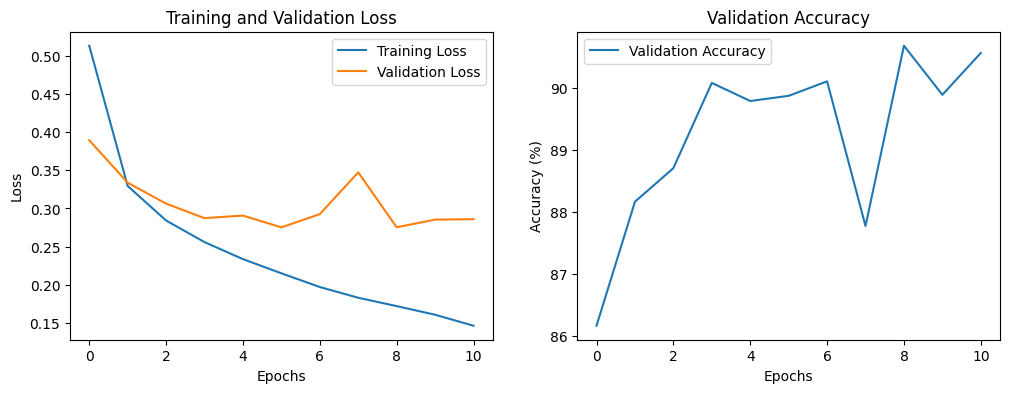

In [7]:
plt.figure(figsize=(12, 4))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

### Accuracy 향상을 위한 작업

1. 데이터 증강: transforms.Compose에서 데이터 증강을 추가하여 모델이 더 다양한 데이터에 노출되도록 했습니다. 이로 인해 모델이 더 다양한 상황에서 잘 일반화될 수 있습니다.
- 데이터 증강: 데이터셋을 더 다양하게 만들기 위해 이미지 회전, 이동, 플립 등의 데이터 증강 기법을 사용할 수 있습니다. 이는 모델이 더 다양한 패턴을 학습하도록 도와주어 성능을 향상시킬 수 있습니다.
```python
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 수평 플립
    transforms.RandomRotation(10),      # 10도 내외로 회전
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
```

2. 네트워크 구조 개선:
- 더 많은 출력 채널을 가진 두 번째 컨볼루션 레이어(conv2)와 배치 정규화 레이어(BatchNorm2d)를 추가했습니다.
- 완전 연결 레이어(fc1, fc2)의 크기를 증가시켰습니다.
- 과적합 방지를 위해 드롭아웃(Dropout)을 추가했습니다.
- 적용:
  - 더 깊은 네트워크: 더 많은 층을 추가하거나 각 층에 더 많은 뉴런을 추가하면 모델이 더 복잡한 패턴을 학습할 수 있습니다. 예를 들어, 현재 모델은 하나의 컨볼루션 레이어와 두 개의 완전 연결 레이어로 구성되어 있습니다. 두 번째 컨볼루션 레이어와 더 많은 완전 연결 레이어를 추가할 수 있습니다.
```python
self.conv2 = nn.Conv2d(20, 50, 5) # 두 번째 컨볼루션 레이어 추가
```

  - 그리고 forward 함수에서 두 번째 컨볼루션 레이어를 추가:
```python
x = self.pool(F.relu(self.conv1(x)))
x = self.pool(F.relu(self.conv2(x)))  # 추가된 레이어
```

  - 드롭아웃(Dropout): 과적합(overfitting)을 방지하기 위해 드롭아웃 레이어를 추가할 수 있습니다. 드롭아웃은 훈련 중 무작위로 뉴런을 비활성화하여 모델의 일반화 능력을 향상시킵니다.
```python
self.dropout = nn.Dropout(0.5)
```

  - 그리고 forward 함수에서 드롭아웃을 적용:
```python
x = self.flatten(x)
x = F.relu(self.fc1(x))
x = self.dropout(x)  # 드롭아웃 적용
x = self.fc2(x)
```

3. 최적화 알고리즘: Adam 최적화 알고리즘을 사용하여 SGD보다 빠르고 안정적으로 학습할 수 있도록 했습니다.
- Adam Optimizer: 현재 SGD를 사용하고 있지만, 더 복잡한 최적화 알고리즘인 Adam을 사용하면 성능이 향상될 수 있습니다. Adam은 학습률을 자동으로 조정해주며, 특히 불안정한 데이터셋에서 좋은 성능을 보입니다.

```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

4. 학습률 스케줄링: StepLR을 사용하여 학습률을 점진적으로 감소시키는 학습률 스케줄러를 추가했습니다.
- 학습률 스케줄러: 학습률이 너무 크거나 너무 작을 경우 모델이 최적의 성능에 도달하지 못할 수 있습니다. 학습률 스케줄러를 사용하면 학습 진행에 따라 학습률을 점진적으로 감소시켜 더 나은 수렴을 이끌어낼 수 있습니다.

```python
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
```

- 학습 루프에서 각 에포크가 끝날 때 스케줄러를 호출해 학습률을 조정합니다:

```python
scheduler.step()
```



그 외에도 적용하지 않았지만 정확도를 향상시키기 위해서는... <br>

5. 배치 정규화(Batch Normalization)
- 배치 정규화: 배치 정규화 레이어를 추가하면 학습 속도를 높이고, 일반화 성능을 향상시킬 수 있습니다. 이는 각 배치에서 레이어의 입력을 정규화하여 모델의 안정성을 높입니다.

```python
self.bn1 = nn.BatchNorm2d(20)
self.bn2 = nn.BatchNorm2d(50)
```
- 그리고 forward 함수에서 배치 정규화를 적용:

```python
x = self.pool(F.relu(self.bn1(self.conv1(x))))
x = self.pool(F.relu(self.bn2(self.conv2(x))))
```

6. 조기 종료 조건 완화
- Patience 증가: 조기 종료의 patience 값을 늘려 모델이 더 많은 에포크 동안 학습할 수 있도록 하면, 더 나은 성능을 얻을 수 있습니다. 다만, 이 방법은 과적합의 위험이 있으므로 신중하게 사용해야 합니다.
7. 모델의 하이퍼파라미터 튜닝
- 학습률: 학습률을 조정하여 성능을 개선할 수 있습니다. 너무 높은 학습률은 불안정한 학습을 유발하고, 너무 낮은 학습률은 학습을 느리게 할 수 있습니다.

Epoch 1, Train Loss: 0.627625, Validation Loss: 0.400419, Accuracy: 85.20%
Validation Loss Decreased(inf--->0.400419) 	 Saving The Model
Epoch 2, Train Loss: 0.454792, Validation Loss: 0.384547, Accuracy: 85.61%
Validation Loss Decreased(0.400419--->0.384547) 	 Saving The Model
Epoch 3, Train Loss: 0.409708, Validation Loss: 0.336135, Accuracy: 87.75%
Validation Loss Decreased(0.384547--->0.336135) 	 Saving The Model
Epoch 4, Train Loss: 0.379993, Validation Loss: 0.332414, Accuracy: 87.67%
Validation Loss Decreased(0.336135--->0.332414) 	 Saving The Model
Epoch 5, Train Loss: 0.363794, Validation Loss: 0.310451, Accuracy: 88.47%
Validation Loss Decreased(0.332414--->0.310451) 	 Saving The Model
Epoch 6, Train Loss: 0.314507, Validation Loss: 0.280305, Accuracy: 89.57%
Validation Loss Decreased(0.310451--->0.280305) 	 Saving The Model
Epoch 7, Train Loss: 0.300213, Validation Loss: 0.278626, Accuracy: 89.72%
Validation Loss Decreased(0.280305--->0.278626) 	 Saving The Model
Epoch 8, Tr

<ipython-input-8-3916a52c4095>:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy on the 10000 test images: 89.39%


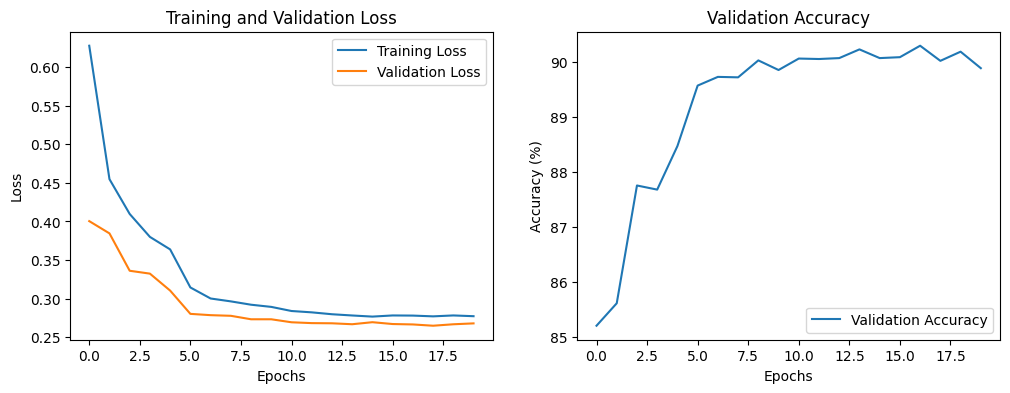

In [8]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# 데이터셋 전처리 및 데이터 증강
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 수평 플립
    transforms.RandomRotation(10),      # 10도 내외로 회전
    transforms.ToTensor(),                # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 평균 0.5, 표준편차 0.5로 정규화
])

# 데이터셋 로드
training_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# 훈련 데이터셋을 훈련 및 검증 세트로 분할
train_size = int(0.8 * len(training_data))  # 80%
val_size = len(training_data) - train_size  # 검증 세트 크기 20%
train_dataset, val_dataset = random_split(training_data, [train_size, val_size])

# 데이터 로더를 생성
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_data, batch_size=64, shuffle=False)

# 모델을 정의 (배치 정규화와 드롭아웃 추가)
class MyImprovedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)  # 더 큰 출력 채널 사용
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화 추가
        self.conv2 = nn.Conv2d(32, 64, 5)  # 두 번째 컨볼루션 레이어 추가
        self.bn2 = nn.BatchNorm2d(64)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 128)  # 더 큰 완전 연결 레이어
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가
        self.fc2 = nn.Linear(128, 10)  # 출력 레이어

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 모델 인스턴스 생성
model = MyImprovedModel().to(device)

# 손실 함수 및 최적화 알고리즘 지정 (Adam Optimizer 사용)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 설정 (에포크마다 학습률 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 모델 훈련
best_val_loss = float('inf')
patience, trials = 5, 0
num_epochs = 20

train_losses = []
val_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # 검증 단계
    val_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    accuracy = 100 * correct / total
    val_losses.append(val_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}, Accuracy: {accuracy:.2f}%")

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
        best_val_loss = val_loss
        trials = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping triggered")
            break

    scheduler.step()  # 학습률 감소

# 저장된 최적 모델 불러오기
model.load_state_dict(torch.load('best_model.pth'))

# 테스트 데이터셋에서 평가
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the 10000 test images: {accuracy:.2f}%')

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [ ]:
############### 강사님 코드

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# 1단계: 신경망 모델 정의
# Net 클래스는 nn.Module을 상속받아 만들어진 사용자 정의 신경망 모델로, FashionMNIST 데이터셋의 이미지 분류를 위해 설계
class Net(nn.Module):
# 모델의 구조를 정의합니다. 이 모델은 세 개의 완전 연결(fully-connected) 레이어를 포함
    def __init__(self):
        super(Net, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1개, 출력 채널 6개, 커널 크기 5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 두 번째 합성곱 레이어: 입력 채널 6개, 출력 채널 16개, 커널 크기 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 전결합 레이어
        self.fc1 = nn.Linear(16*4*4, 120)  # 입력으로 28x28 크기의 이미지를 받아 펼친 후(784개의 피처), 120개의 출력 노드로 연결
        self.fc2 = nn.Linear(120, 84) # 120개의 입력 노드에서 84개의 출력 노드로 연결
        self.fc3 = nn.Linear(84, 10)  # 84개의 입력 노드에서 최종적으로 10개의 출력 노드로 연결
# forward 메소드는 신경망에 데이터를 어떻게 전달할지 정의
    def forward(self, x):
        # 첫 번째 합성곱, ReLU 활성화, 맥스 풀링
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # 두 번째 합성곱, ReLU 활성화, 맥스 풀링
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # 입력 데이터를 1차원으로 펼침
        x = x.view(-1, 16*4*4) # 입력 이미지 x를 1차원으로 펼치는 과정입니다. -1은 배치 크기에 대응되며, 이는 어떤 크기의 배치라도 처리할 수 있음을 의미
        x = F.relu(self.fc1(x)) # 첫 번째 레이어를 통과한 후, ReLU 활성화 함수를 적용합니다. 이는 비선형성을 도입하여 모델이 더 복잡한 패턴을 학습
        x = F.relu(self.fc2(x)) # 두 번째 레이어를 통과한 후, 다시 ReLU 활성화 함수를 적용
        x = self.fc3(x) # 세 번째 레이어를 통과한 결과를 반환. 소프트맥스 함수 등을 통해 확률로 변환되어 클래스를 예측하는 데 사용
        return x
# 2단계: FashionMNIST 데이터셋 로드
# torchvision 라이브러리를 사용하여 FashionMNIST 데이터셋을 다운로드하고, 데이터를 전처리하기 위한 변환(transform)을 설정하는 과정

# transforms.Compose는 여러 전처리 단계를 하나로 묶어주는 역할
# transforms.ToTensor(): 이미지를 PyTorch 텐서로 변환. 이미지의 픽셀 값 범위가 0에서 255 사이의 정수에서 0.0에서 1.0 사이의 부동소수점으로 변경
# 모든 채널의 평균을 0.5로, 표준편차를 0.5로 설정합니다. 이는 데이터의 범위를 대략적으로 -1.0에서 1.0 사이로 조정
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# FashionMNIST 데이터셋을 다운로드하고, 지정된 변환을 적용하여 데이터를 준비하는 함수
train_val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 훈련 및 검증 분할을 위한 데이터 인덱스 생성
dataset_size = len(train_val_dataset) # 훈련 및 검증 데이터셋의 전체 크기
indices = list(range(dataset_size)) # 데이터셋 내의 모든 샘플에 대한 인덱스를 포함
validation_split = 0.1 # 검증 세트로 사용될 데이터의 비율
split = int(np.floor(validation_split * dataset_size)) # 검증 세트의 크기를 계산
np.random.shuffle(indices) # 훈련 및 검증 세트가 데이터셋의 특정 부분에 치우치지 않도록 하기 위함
train_indices, val_indices = indices[split:], indices[:split] # 섞인 인덱스를 사용하여 훈련 세트와 검증 세트의 인덱스를 분할

# PT 데이터 샘플러 및 로더 생성
# 훈련 세트와 검증 세트에 대한 데이터 로더를 설정하고, 테스트 세트에 대한 데이터 로더를 별도로 설정하는 과정입니다.
# 이러한 데이터 로더들은 모델 학습, 검증, 테스트 과정에서 배치 단위로 데이터를 로드하는 데 사용
train_sampler = SubsetRandomSampler(train_indices) # train_indices에 해당하는 훈련 데이터의 인덱스를 무작위로 샘플링하는 샘플러를 생성
val_sampler = SubsetRandomSampler(val_indices) # val_indices에 해당하는 검증 데이터의 인덱스로부터 데이터를 무작위로 샘플링하는 샘플러를 생성
# 배치 크기 4로 로드하는 훈련 데이터 로더를 생성(# 데이터의 무작위 샘플링을 수행)
trainloader = torch.utils.data.DataLoader(train_val_dataset, batch_size=4, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(train_val_dataset, batch_size=4, sampler=val_sampler)
# shuffle=False 인자를 통해 셔플링 없이 순서대로 데이터를 로드. 테스트 과정에서는 데이터의 순서가 결과에 영향을 미치지 않으므로 셔플링을 수행하지 않습니다.
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# 3단계: 네트워크, 손실 함수, 최적화 알고리즘 초기화
net = Net() #  클래스의 인스턴스를 생성하여 net 변수에 할당
criterion = nn.CrossEntropyLoss() # 멀티클래스 분류 문제에서 널리 사용되는 손실 함수로, 모델의 예측값과 실제 타겟값 사이의 차이를 측정
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 모멘텀은 최적화 과정에서 이전 그래디언트의 방향을 고려, 파라미터 업데이트 시 관성을 부여

# 4단계: 조기 종료를 포함한 모델 학습
patience = 5 # 검증 손실이 개선되지 않을 때, 훈련을 계속 진행하기 전에 기다릴 에폭 수를 의미
patience_counter = 0
best_val_loss = np.Inf # 최고의 검증 손실 값을 무한대로 초기화. 훈련 과정에서 검증 손실이 이전에 기록된 최소 손실보다 낮아지면 업데이트되는 값

# 모델을 에폭 단위로 반복 훈련시키면서, 각 배치의 손실을 계산하고 모델 파라미터를 업데이트하는 기본적인 훈련 과정을 구현
for epoch in range(20):  # 데이터셋을 여러 번 반복
    net.train()  # 모델을 학습 모드로 설정. 이는 모델 내의 특정 레이어(예: 드롭아웃, 배치 정규화 등)가 훈련 시와 평가 시 다르게 동작해야 할 때 필요
    running_loss = 0.0 # 현재 에폭의 총 손실을 계산하기 위해 실행 손실을 0으로 초기화
    for i, data in enumerate(trainloader, 0): # '0'은 열거의 시작 인덱스를 지정
        inputs, labels = data
        optimizer.zero_grad() # 최적화를 수행하기 전에 모델의 그래디언트를 0으로 초기화
        outputs = net(inputs) # 현재 배치의 입력 데이터를 모델에 전달하여 예측값을 계산
        loss = criterion(outputs, labels) # 모델의 예측값과 실제 레이블 간의 손실을 계산
        loss.backward() # 손실 함수의 그래디언트를 역전파합니다. 이 과정에서 모델 파라미터에 대한 손실의 미분값이 계산
        optimizer.step() # 계산된 그래디언트를 사용하여 모델의 파라미터를 업데이트
        running_loss += loss.item() # 현재 배치의 손실을 실행 손실에 누적. 이를 통해 전체 에폭의 평균 손실을 계산

    # 검증 단계
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0 # 검증 손실을 계산하기 위한 변수를 0으로 초기화
    with torch.no_grad(): # 이 블록 내에서는 그래디언트 계산을 비활성화. 평가 모드에서는 모델을 업데이트하지 않으므로, 그래디언트를 계산할 필요가 없습니다
        for inputs, labels in valloader: # 검증 데이터 로더(valloader)에서 배치 단위로 데이터를 로드하여 반복
            outputs = net(inputs)
            loss = criterion(outputs, labels) # criterion은 손실 함수로, 모델의 성능을 측정하는 기준
            val_loss += loss.item() # 누적된 검증 손실을 검증 데이터 배치의 총 수로 나누어 평균 검증 손실을 계산
    running_loss /= len(trainloader)
    val_loss /= len(valloader)
    print(f'에폭 {epoch + 1}, 훈련 손실: {running_loss}, 검증 손실: {val_loss}')

    # 조기 종료 체크
    if val_loss < best_val_loss: # 현재 에폭에서 계산된 검증 손실(val_loss)이 이전에 기록된 최소 검증 손실(best_val_loss)보다 낮은지 확인
        print(f'검증 손실이 감소하였습니다. ({best_val_loss:.6f} 에서 {val_loss:.6f}로). 모델 저장 중...')
        torch.save(net.state_dict(), '/content/drive/MyDrive/KITA_2024/M6_DeepLearning/DATA/model/best_model.pth')
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('조기 종료 발동.')
            break

# 5단계: 최고의 모델을 로드하고 테스트 데이터셋으로 평가
# torch.load 함수는 지정된 경로에서 모델 파라미터를 불러오며, load_state_dict 메서드를 사용하여 이 파라미터를 현재 net 모델에 로드
net.load_state_dict(torch.load('/content/drive/MyDrive/KITA_2024/M6_DeepLearning/DATA/model/best_model.pth'))
correct = 0 # 정확히 분류된 샘플의 수를 세기 위한 변수
total = 0 # 테스트셋의 전체 샘플 수를 세기 위한 변수
with torch.no_grad():
    for data in testloader: # 테스트 데이터셋을 배치 단위로 순회
        images, labels = data
        outputs = net(images) # 현재 배치의 이미지를 모델에 전달하여 예측값을 계산
        _, predicted = torch.max(outputs.data, 1) # torch.max는 각 예측에 대한 최대값과 그 위치(인덱스)를 반환. 위치만 필요하므로 _를 사용하여 최대값은 무시
        total += labels.size(0) # labels.size(0)는 현재 배치의 크기(샘플 수)
        correct += (predicted == labels).sum().item() # 일치하는 경우의 수를 텐서 형태로 반환하며, .item()으로 이를 파이썬의 스칼라 값으로 변환

print(f'10000개의 테스트 이미지에 대한 네트워크의 정확도: {100 * correct / total} %')



에폭 1, 훈련 손실: 0.645499868438868, 검증 손실: 0.4237605184833131
검증 손실이 감소하였습니다. (inf 에서 0.423761로). 모델 저장 중...
에폭 2, 훈련 손실: 0.3842360920384106, 검증 손실: 0.36171746428027596
검증 손실이 감소하였습니다. (0.423761 에서 0.361717로). 모델 저장 중...
에폭 3, 훈련 손실: 0.3335339011658639, 검증 손실: 0.32261592026337166
검증 손실이 감소하였습니다. (0.361717 에서 0.322616로). 모델 저장 중...
에폭 4, 훈련 손실: 0.30343043210211323, 검증 손실: 0.31553335761450824
검증 손실이 감소하였습니다. (0.322616 에서 0.315533로). 모델 저장 중...
에폭 5, 훈련 손실: 0.28483923283633095, 검증 손실: 0.30512529630904706
검증 손실이 감소하였습니다. (0.315533 에서 0.305125로). 모델 저장 중...
에폭 6, 훈련 손실: 0.2677996156277164, 검증 손실: 0.3031721923639319
검증 손실이 감소하였습니다. (0.305125 에서 0.303172로). 모델 저장 중...
에폭 7, 훈련 손실: 0.25438536807183154, 검증 손실: 0.28437095567816867
검증 손실이 감소하였습니다. (0.303172 에서 0.284371로). 모델 저장 중...
에폭 8, 훈련 손실: 0.24324978774377817, 검증 손실: 0.27773658363720943
검증 손실이 감소하였습니다. (0.284371 에서 0.277737로). 모델 저장 중...
에폭 9, 훈련 손실: 0.23199004295915363, 검증 손실: 0.2787772588444786
에폭 10, 훈련 손실: 0.22450584982834948, 검증 손실: 0.2788

<ipython-input-9-1a97279b567e>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('/content/drive/MyDrive/KITA_2024/M6_DeepLearning/DATA/model

10000개의 테스트 이미지에 대한 네트워크의 정확도: 89.79 %


In [ ]:
##### 위의 Network을 아래와 같이 쓸 수도 있음.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1개, 출력 채널 6개, 커널 크기 5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 두 번째 합성곱 레이어: 입력 채널 6개, 출력 채널 16개, 커널 크기 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # 전결합 레이어
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 16개의 채널과 4x4 이미지 크기
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 첫 번째 합성곱, ReLU 활성화, 맥스 풀링
        x = self.pool(F.relu(self.conv1(x)))
        # 두 번째 합성곱, ReLU 활성화, 맥스 풀링
        x = self.pool(F.relu(self.conv2(x)))
        # 입력 데이터를 1차원으로 펼침
        x = self.flatten(x)
        # x = x.view(-1, 16 * 4 * 4)
        # 전결합 레이어와 ReLU 활성화 함수 적용
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # 마지막 레이어 출력
        x = self.fc3(x)
        return x

Task1_0829. 가상 데이터 생성 (generate_data 함수) 후 모델링 및 평가하세요
- generate_data 함수는 1000개의 랜덤 시퀀스 데이터를 생성합니다.
  - vocab_size: 시퀀스에 사용할 어휘의 크기를 설정합니다. 여기서는 100개의 단어를 사용합니다.
  - data: 각 시퀀스는 seq_length=10으로 설정된 10개의 정수(단어 인덱스)로 구성됩니다.
  - labels: 각 시퀀스에 대해 0 또는 1의 이진 레이블을 무작위로 할당합니다.

- LSTM 기반 분류 모델을 정의하고, 가상 데이터로 학습 및 검증을 수행합니다.
- 조기 종료를 통해 학습 중 성능이 더 이상 개선되지 않을 때 학습을 중단합니다.
최종적으로 테스트 데이터로 최고 성능의 모델을 평가합니다.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# 가상 데이터 생성 함수
def generate_data(num_samples=1000, seq_length=10):
    vocab_size = 100  # 어휘집 크기
    data = torch.randint(0, vocab_size, (num_samples, seq_length))
    labels = torch.randint(0, 2, (num_samples,))  # 0 또는 1의 레이블
    return data, labels

# 데이터 생성
data, labels = generate_data()

# TensorDataset 및 DataLoader 생성
dataset = TensorDataset(data, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# LSTM 기반 분류 모델 정의
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(out)
        return out

# 모델 인스턴스 생성
vocab_size = 100
embedding_dim = 64
hidden_dim = 128
output_dim = 2  # 이진 분류

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)

# 손실 함수 및 최적화 알고리즘 지정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 조기 종료 설정
patience = 5
best_val_loss = float('inf')
trials = 0

# 모델 훈련
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # 조기 종료 조건 확인
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trials = 0
        torch.save(model.state_dict(), "best_lstm_model.pth")
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping triggered")
            break

# 최적 모델 로드 및 테스트 평가
model.load_state_dict(torch.load("best_lstm_model.pth"))

# 테스트 데이터 생성 및 평가 (테스트 데이터를 학습 데이터의 일부로 생성)
test_data, test_labels = generate_data(num_samples=200, seq_length=10)
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1, Train Loss: 0.6918, Validation Loss: 0.6930, Validation Accuracy: 0.4900
Epoch 2, Train Loss: 0.6680, Validation Loss: 0.7019, Validation Accuracy: 0.4650
Epoch 3, Train Loss: 0.6408, Validation Loss: 0.7166, Validation Accuracy: 0.5050
Epoch 4, Train Loss: 0.6052, Validation Loss: 0.7786, Validation Accuracy: 0.5000
Epoch 5, Train Loss: 0.5518, Validation Loss: 0.8190, Validation Accuracy: 0.4800
Epoch 6, Train Loss: 0.4778, Validation Loss: 0.9481, Validation Accuracy: 0.5050
Early stopping triggered
Test Accuracy: 0.5550


<ipython-input-10-922daf21396a>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_model.pth"))


### 코드 분석
1. 데이터 생성 (generate_data):
- generate_data 함수는 num_samples 만큼의 랜덤 시퀀스 데이터를 생성합니다. 각 시퀀스는 seq_length만큼의 정수로 이루어져 있으며, 각 정수는 vocab_size 범위 내에서 무작위로 생성됩니다.
- 각 시퀀스에 대해 0 또는 1의 이진 레이블을 무작위로 할당합니다.

2. 데이터 로드 및 분할:
- TensorDataset으로 데이터셋을 구성한 뒤, 이를 train_dataset과 - val_dataset으로 80:20 비율로 분할합니다.
- DataLoader를 통해 데이터셋을 배치 단위로 로드할 수 있도록 설정합니다.

3. LSTM 기반 분류 모델 정의 (LSTMClassifier):
- nn.Embedding을 사용해 시퀀스 데이터를 임베딩합니다.
- nn.LSTM 레이어를 사용하여 시퀀스를 처리합니다.
- nn.Linear를 통해 마지막 LSTM 출력에서 이진 분류를 수행합니다.

4. 모델 훈련 및 조기 종료:
- Adam 최적화 알고리즘을 사용하여 모델을 학습합니다.
- 검증 손실이 일정 에포크 동안 개선되지 않을 경우 조기 종료(Early Stopping)를 실행합니다.

5. 테스트 평가:
- 최적의 성능을 가진 모델을 로드한 후, 별도로 생성한 테스트 데이터로 모델의 성능을 평가합니다.